# Abhishek Kumar Shastry


## Section 0: Loading the data

There is no code for you to fill out in this section but please make sure you understand what the code* is doing so you aren't confused in later parts. Basically, this section loads the training, testing, and validation data of the dog images for you.

In [71]:
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation, Input, LeakyReLU
from keras.models import Model, Sequential
from keras.utils import np_utils
from keras.preprocessing import image    
from matplotlib import pyplot
from scipy.misc import toimage
from tqdm import tqdm
from glob import glob
from PIL import Image
from PIL import ImageEnhance
from random import *
import keras.backend as K
from keras import optimizers
import cv2
#from keras.applications.vgg16 import preprocess_input

In [2]:
K.set_image_dim_ordering('tf')

Loads the datasets and gets list of dog names (labels). `X_train`, `X_val`, and `X_test` contain lists of image paths to the data.

In [3]:
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

X_train, y_train = load_dataset('dogImages/train')
X_val, y_val = load_dataset('dogImages/valid')
X_test, y_test = load_dataset('dogImages/test')

# List of all dog names
labels = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

In [4]:
no_of_classes=np.size(y_train[1])
Training_Set_Size=np.size(X_train)

`load_image` takes in a string containing a path to an image, loads the image file, converts it into a array matrix, resizes it go be `64x64`, and normalizes all the values to be between 0 and 1.

In [5]:
def load_image(path, size=48):
    #img = Image.open(path.strip())
    #print(img.mode)
    img = cv2.imread(path.strip())#BGR
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, np.float32)
    img = scipy.misc.imresize(img, (size, size))
    
    return img

/home/shastry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


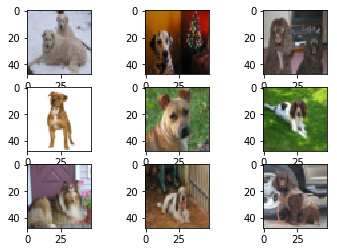

In [6]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(load_image(X_train[i]))
# show the plot
pyplot.show()


## Section 1: Data augmentation

In this section we want you to perform some sort of data augmentation as we learnt about in class. This is because we only have roughly 200 examples per label which in deep learning isn't generally enough. Therefore, to improve performance we can use data augmentation as a trick to generate more training examples.

Make sure you try at least **TWO** methods of augmentation. Please explain each augmentation and what it does as well as visualizing at least one example of each augmentation. If you do choose to try more, make sure to incremement `NB_AUGMENTATIONS` by one each time.

If you want to change the size of your image (smaller images train faster), you want to change `IMG_SIZE`.

An example augmentation of flipping the image has already been done for you in `example_augment`.

I have used random cropping of images and resizing for zoom and changing brightness, contrast and sharpness of images for image augmentations

In [120]:
def example_augment(img):
    augmented_img = np.fliplr(img)
    return augmented_img

**Augmentation Explanation:** This function crops the image randomly with the corners lying within the 15% of each quadrant and then resizes the image with the effect of zoom in the final image.

In [121]:
def augmentation_1(img):
    img=Image.fromarray(img)
    w,h=img.size
    crop_factor=0.15;
    box=((int(random()*crop_factor*w),int(random()*crop_factor*h),int(w-random()*crop_factor*w),int(h-random()*crop_factor*h)))
    img=img.crop(box)
    img=img.resize((w,h))
    # Random cropping and resizing. The effect is zoom and streching
    augmented_img = np.array(img);
    return augmented_img

**Augmentation Explanation:** This function changes the brighness, contrast and sharpness of images randomly within a specified range.

In [11]:
def augmentation_2(img):
    img=Image.fromarray(img)
    enhance_factor_min=0.6
    enhance_factor_max=1.15;

    img=ImageEnhance.Brightness(img).enhance(enhance_factor_min+random()*enhance_factor_max);
    img=ImageEnhance.Contrast(img).enhance(enhance_factor_min+random()*enhance_factor_max);
    img=ImageEnhance.Sharpness(img).enhance(enhance_factor_min+random()*enhance_factor_max);
    # Random brightness, contrast and sharpness adjustments
    augmented_img = np.array(img);
    return augmented_img

/home/shastry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


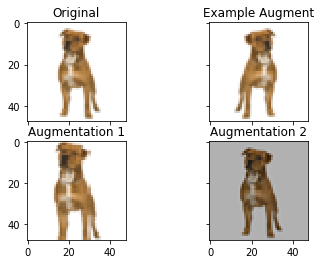

In [12]:
sample_img = load_image(X_train[3])
f, axarr = plt.subplots(2, 2)
axarr[0, 0].imshow(sample_img)
axarr[0, 0].set_title('Original')
axarr[0, 1].imshow(example_augment(sample_img))
axarr[0, 1].set_title('Example Augment')
axarr[1, 0].imshow(augmentation_1(sample_img))
axarr[1, 0].set_title('Augmentation 1')
axarr[1, 1].imshow(augmentation_2(sample_img))
axarr[1, 1].set_title('Augmentation 2')

for ax in axarr.flat:
    ax.label_outer()

In [26]:
NB_AUGMENTATIONS = 3
IMG_SIZE = 221

def batch_generator(images, labels, augment=True, batch_size=40):
    batch_images = []
    batch_labels = []
    sample_count = 0
    
    while True:
        # Shuffle indices to minimize overfitting.
        for i in np.random.permutation(images.shape[0]):
        #for i in range(images.shape[0]):

            img_path = images[i]
            label = labels[i]

            img = load_image(img_path, size=IMG_SIZE)
            batch_images.append(img)
            batch_labels.append(label)
            sample_count += 1

            if augment:
                # Perform Augmentation (Flipping the Image)
                img_example_augment = example_augment(img)
                batch_images.append(img_example_augment)
                batch_labels.append(label)
                
                # Perform Augmentation 1
                img_augment_1 = augmentation_1(img)
                batch_images.append(img_augment_1)
                batch_labels.append(label)

                # Perform Augmentation 2
                img_augment_2 = augmentation_2(img)
                batch_images.append(img_augment_2)
                batch_labels.append(label)

            if ((sample_count % batch_size == 0) or (sample_count % len(images) == 0)):
                yield np.array(batch_images), np.array(batch_labels)
                # Reset batch.
                batch_images = []
                batch_labels = []

## Section 2: Building the model

In this section you will write all the code to build your Convolutional Neural Network model in Keras. The model should output `NUM_CLASSES` (133 in this case) values which sum up to 1 and are each the probability that the dog is of the respective breed.

**Explanation:** Here I import the base model which is inception_resnet_v2 and add the preprocessing layer to it to create the base model for generating bottle-neck features.

In [27]:
from keras.applications.inception_resnet_v2 import preprocess_input
pretrained_model = applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet',input_shape = (IMG_SIZE ,IMG_SIZE ,3),pooling='avg')
inputs = Input((IMG_SIZE, IMG_SIZE, 3))
x = Lambda(preprocess_input, name='preprocessing')(inputs)
outputs = pretrained_model(x) 
base_model = Model(inputs, outputs) 


1.4.1


Here I feed the training images from the batch generator into the base model and obtain an array with the bottleneck features.

In [41]:
bach_size=32;

bottleneck_features_train=[];
bottleneck_labels_train=[];
step=0
max_step=150;
augmt=True;
for x_batch, y_batch in batch_generator(X_train, y_train, augment=augmt, batch_size=bach_size):
    bottleneck_features_train.append(base_model.predict(x_batch,batch_size=bach_size))
    bottleneck_labels_train.append(y_batch)
    step=step+1;
    print(step)
    if (step==max_step):break
train_data=np.vstack(bottleneck_features_train)
train_labels=np.vstack(bottleneck_labels_train)



/home/shastry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


Here I feed the validation data into base model to get the bottleneck features for the validation data.

In [43]:
bottleneck_features_val=[];
bottleneck_labels_val=[];
step=0
max_step=30;
for x_batch, y_batch in batch_generator(X_val, y_val, augment=False, batch_size=bach_size):
    bottleneck_features_val.append(base_model.predict(x_batch,batch_size=bach_size))
    bottleneck_labels_val.append(y_batch)
    print(len(bottleneck_labels_val))
    step=step+1;
    if (step==max_step):break
val_data=np.vstack(bottleneck_features_val)
val_labels=np.vstack(bottleneck_labels_val)
print(val_data.shape)
print(val_labels.shape)




/home/shastry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
(928, 1536)
(928, 133)


Here I create the final dense layers which will be trained on the bottleneck features

In [117]:

top_model = Sequential()
#top_model.add(Flatten(input_shape=train_data.shape[1:]))
#top_model.add(Dense(1024, activation='relu'))
#top_model.add(Dropout(0.5))
#top_model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
top_model.add(Dense(1024, input_shape=train_data.shape[1:], kernel_initializer='uniform'))
top_model.add(BatchNormalization())
top_model.add(LeakyReLU(0.8))
top_model.add(Dropout(0.8))
#top_model.add(Dense(1024, use_bias=False, kernel_initializer='uniform'))
#top_model.add(BatchNormalization())
#top_model.add(Activation("relu"))
#top_model.add(Dropout(0.5))
top_model.add(Dense(133, kernel_initializer='uniform', activation="softmax"))

#top_model.add(Dense(1024, kernel_initializer='uniform', activation='relu'))
#BatchNormalization()
#top_model.add(Dropout(0.5))
#top_model.add(Dense(no_of_classes, activation='softmax'))

top_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 1024)              1573888   
_________________________________________________________________
batch_normalization_424 (Bat (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 133)               136325    
Total params: 1,714,309
Trainable params: 1,712,261
Non-trainable params: 2,048
_________________________________________________________________


## Section 3: Training the model

The code to train your model has been done for you already as it is a bit different than before due to the batch generator. Notice how we set `augment` to false for the validation generator. It is important never to augment your validation nor testing data since that can bias (inflate or deflate) the accuracy scores. The code also saves your models weights in the end which we can use for testing later on so we don't have to retrain it entirely.

The optimizer parameters were chosen through a very coarse parameter sweep

In [118]:
top_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.8), metrics=['accuracy'])

In [119]:
history=top_model.fit(train_data, train_labels,
              epochs=30,
              batch_size=40,
              validation_data=(val_data, val_labels),verbose=1)

Train on 19200 samples, validate on 928 samples
Epoch 1/30
19200/19200 [==============================] - 22s 1ms/step - loss: 4.6918 - acc: 0.1116 - val_loss: 1.8900 - val_acc: 0.7155
Epoch 2/30
19200/19200 [==============================] - 15s 788us/step - loss: 2.2871 - acc: 0.4798 - val_loss: 0.9271 - val_acc: 0.7716
Epoch 3/30
19200/19200 [==============================] - 15s 782us/step - loss: 1.4705 - acc: 0.6483 - val_loss: 0.6941 - val_acc: 0.7866
Epoch 4/30
19200/19200 [==============================] - 15s 785us/step - loss: 1.1697 - acc: 0.7013 - val_loss: 0.5990 - val_acc: 0.7931
Epoch 5/30
19200/19200 [==============================] - 15s 798us/step - loss: 1.0206 - acc: 0.7331 - val_loss: 0.5476 - val_acc: 0.8060
Epoch 6/30
19200/19200 [==============================] - 15s 802us/step - loss: 0.9019 - acc: 0.7536 - val_loss: 0.5236 - val_acc: 0.8136
Epoch 7/30
19200/19200 [==============================] - 15s 801us/step - loss: 0.8449 - acc: 0.7655 - val_loss: 0.5032

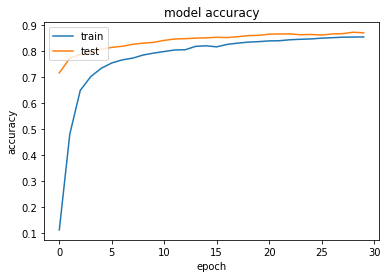

In [122]:
# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

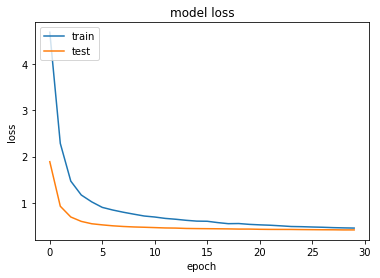

In [123]:
# Summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Saving the weights

In [128]:
import simplejson as json
top_model.save_weights('model.h5', True)
with open('model.json', 'w') as outfile:
    json.dump(top_model.to_json(), outfile)

## Section 4: Evaluation

In this section you will compute the accuracy of your model on the test data from Section 0. Make sure you very clearly have a cell that outputs and prints the percentage accuracy of your model. You will also include any code used to analyze the results here.

A confusion matrix would be nice but since there are so many classes it will be hard to cleanly visualize. Instead f1, precision, and recall scores for each class would be cleaner to read.

**Explanation:** Here I pass the test data through the base model to generate its bottlneck features.

In [129]:



bottleneck_features_test=[];
bottleneck_labels_test=[];
step=0
max_step=15;
for x_batch, y_batch in batch_generator(X_test, y_test, augment=False, batch_size=bach_size):

    bottleneck_features_test.append(base_model.predict(x_batch))
    bottleneck_labels_test.append(y_batch)
    print(len(bottleneck_labels_test))
    step=step+1;
    if (step==max_step):break
test_data=np.vstack(bottleneck_features_val)
test_labels=np.vstack(bottleneck_labels_val)



/home/shastry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  import sys


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Here I pass the bottleneck features into the top dense layer to make predictions and generate the accuray score.

In [170]:
from sklearn.metrics import classification_report, accuracy_score
y_pred = top_model.predict(test_data)
y_test_class = np.argmax(test_labels,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)

0.8696120689655172


Here I print the precision, recall and f1-score

In [172]:

print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00         8
          1       1.00      1.00      1.00         8
          2       1.00      0.86      0.92         7
          3       1.00      0.91      0.95        11
          4       0.90      1.00      0.95         9
          5       1.00      0.80      0.89        10
          6       0.60      0.38      0.46         8
          7       0.80      0.89      0.84         9
          8       0.67      1.00      0.80         4
          9       1.00      0.83      0.91         6
         10       0.69      1.00      0.82         9
         11       0.89      1.00      0.94         8
         12       1.00      0.43      0.60         7
         13       1.00      1.00      1.00         8
         14       1.00      0.89      0.94         9
         15       0.67      1.00      0.80         8
         16       0.88      0.88      0.88         8
         17       1.00      0.83      0.91   

Here I find the top 3 worse performing breeds.

In [169]:
from sklearn.metrics import f1_score
f1=f1_score(y_test_class,y_pred_class, average=None)
f1_sort=f1.argsort()
for i in range(3):
    print(labels[f1_sort[i]])

Icelandic_sheepdog
Lowchen
Irish_red_and_white_setter


In [167]:
from sklearn.metrics import precision_score
f1=precision_score(y_test_class,y_pred_class, average=None)
f1_sort=f1.argsort()
for i in range(3):
    print(labels[f1_sort[i]])

Icelandic_sheepdog
Lowchen
Irish_red_and_white_setter


In [168]:
from sklearn.metrics import recall_score
f1=recall_score(y_test_class,y_pred_class, average=None)
f1_sort=f1.argsort()
for i in range(3):
    print(labels[f1_sort[i]])

Icelandic_sheepdog
Lowchen
Norwegian_buhund
